In [1]:
import torch
import random
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine
%matplotlib notebook
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [2]:
wine = load_wine()

In [3]:
wine.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [4]:
features =  13

X_train, X_test, y_train, y_test = train_test_split(
    wine.data[:, :features], 
    wine.target, 
    test_size=0.3, 
    shuffle=True)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

In [5]:
class WineNet(torch.nn.Module):
    def __init__(self,n_input, n_hidden_neurons):
        super(WineNet, self).__init__()
        self.fc1 = torch.nn.Linear(n_input, n_hidden_neurons)
        self.activ1 = torch.nn.LeakyReLU(inplace = True)
        self.fc2 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ2 = torch.nn.BatchNorm1d(n_hidden_neurons)
        self.fc3 = torch.nn.Linear(n_hidden_neurons, n_hidden_neurons)
        self.activ3 = torch.nn.Dropout(p = 0.2)
        self.fc4 = torch.nn.Linear(n_hidden_neurons, 3)
        self.sm = torch.nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.activ1(x)
        x = self.fc2(x)
        x = self.activ2(x)
        x = self.fc3(x)
        x = self.activ3(x)
        x = self.fc4(x)
        return x

    def inference(self, x):
        x = self.forward(x)
        x = self.sm(x)
        return x
    
n_input =  features
n_hidden =  50
wine_net = WineNet(n_input, n_hidden)

In [6]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wine_net.parameters(), lr=0.0003)

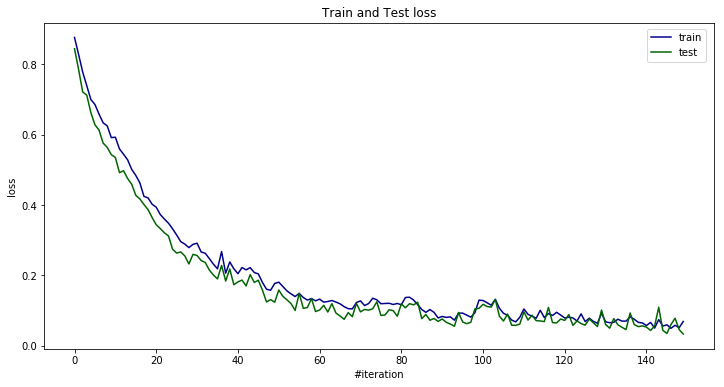

In [7]:
import matplotlib.pyplot as plt
batch_size =  25
loss_history_train = []
loss_history_test = []
for epoch in range(150):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        x_batch = X_train[batch_indexes]
        y_batch = y_train[batch_indexes]
        
        preds = wine_net.forward(x_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
    test_preds = wine_net.forward(X_test)
    train_preds = wine_net.forward(X_train)
    loss_history_train.append(loss(train_preds, y_train))
    loss_history_test.append(loss(test_preds, y_test))
    display.clear_output(wait=True)
    plt.figure(figsize=(12, 6))        
    plt.title("Train and Test loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history_train, 'b', color = 'darkblue', label="train")
    plt.plot(loss_history_test, 'b', color = 'darkgreen', label="test")
    plt.legend(bbox_to_anchor=(0.9, 0.88), loc=3, borderaxespad=0.)
    plt.show()

In [9]:
test_preds = wine_net.inference(X_test)
print(wine_net.fc1.in_features, np.asarray((test_preds.argmax(1) == y_test).float().mean()) > 0.8)
print(np.asarray((test_preds.argmax(1) == y_test).float().mean()))

13 True
1.0
